In [16]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
from nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dropout, TimeDistributed
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [27]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 50

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
toxic = train[train['toxic'] == 1]
severe_toxic = train[train['severe_toxic'] == 1]
obscene = train[train['obscene']==1]
threat = train[train['threat'] == 1]
insult = train[train['insult'] == 1]
identity_hate = train[train['identity_hate'] == 1]

In [6]:
toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


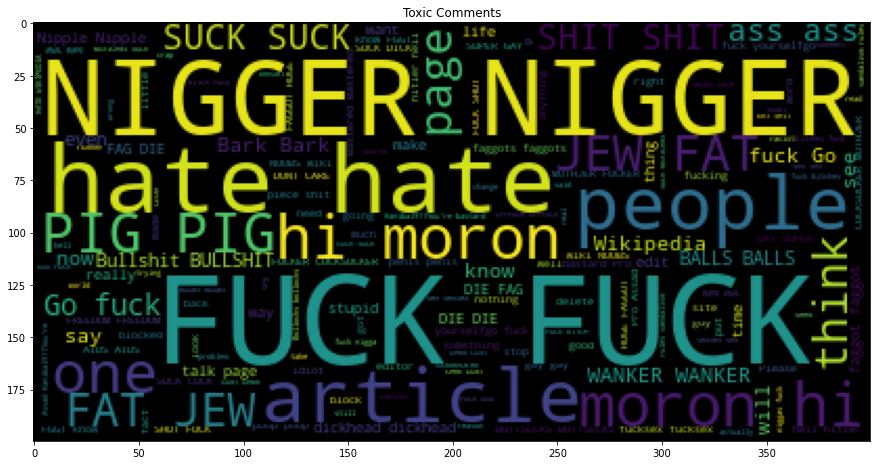

In [8]:
sent = toxic['comment_text'].tolist()
sent_joined = ''.join(sent)
plt.figure(figsize=(15,15))
plt.title("Toxic Comments")
plt.imshow(WordCloud().generate(sent_joined))

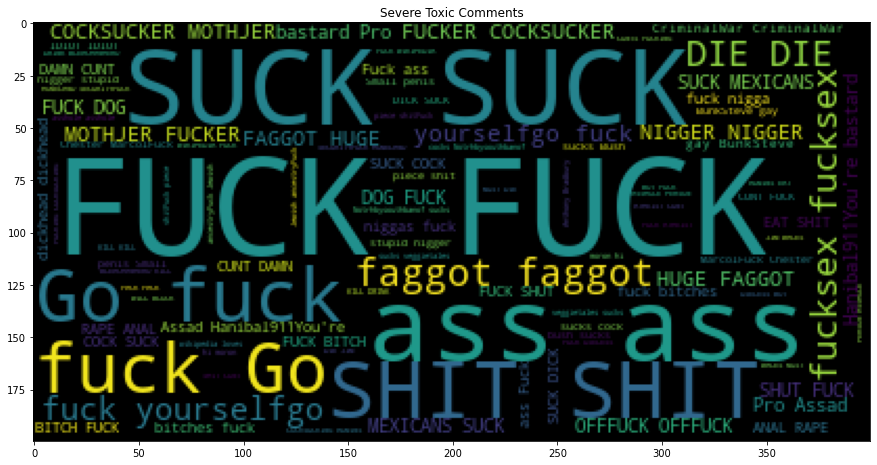

In [9]:
sent = severe_toxic['comment_text'].tolist()
sent_joined = ''.join(sent)
plt.figure(figsize=(15,15))
plt.title("Severe Toxic Comments")
plt.imshow(WordCloud().generate(sent_joined))

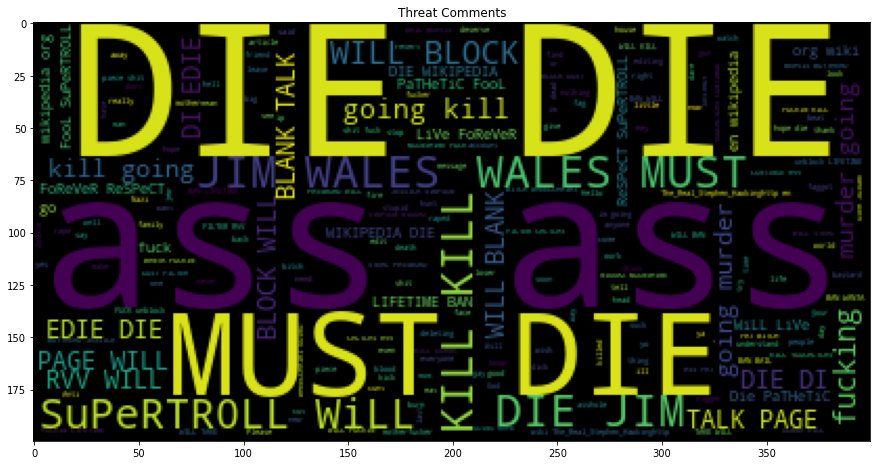

In [10]:
sent = threat['comment_text'].tolist()
sent_joined = ''.join(sent)
plt.figure(figsize=(15,15))
plt.title("Threat Comments")
plt.imshow(WordCloud().generate(sent_joined))

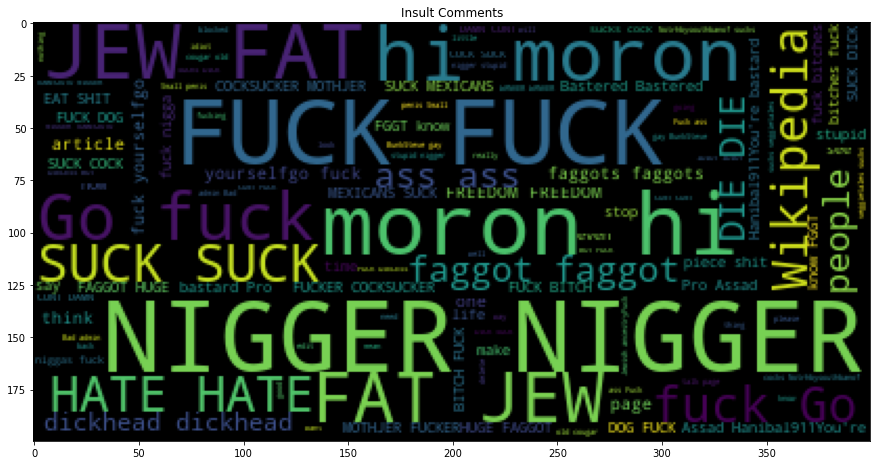

In [11]:
sent = insult['comment_text'].tolist()
sent_joined = ''.join(sent)
plt.figure(figsize=(15,15))
plt.title("Insult Comments")
plt.imshow(WordCloud().generate(sent_joined))

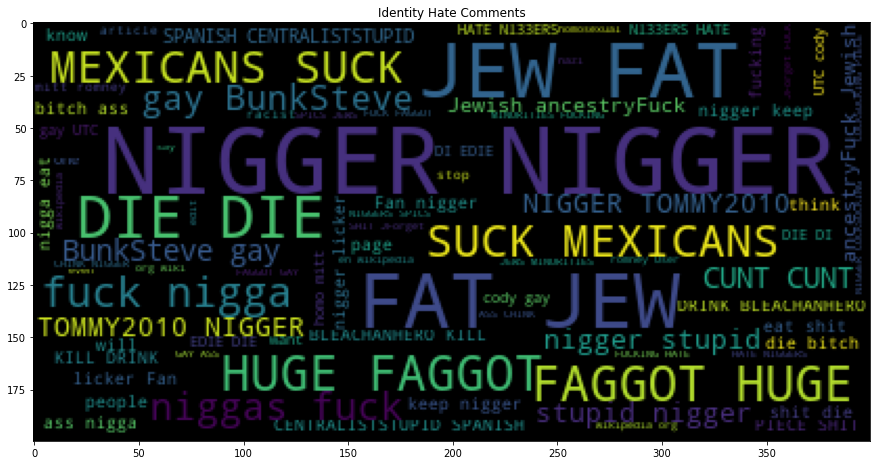

In [12]:
sent = identity_hate['comment_text'].tolist()
sent_joined = ''.join(sent)
plt.figure(figsize=(15,15))
plt.title("Identity Hate Comments")
plt.imshow(WordCloud().generate(sent_joined))

In [13]:

toxic_ = (toxic.shape[0]/train.shape[0])*100
severe_toxic_ = (severe_toxic.shape[0]/train.shape[0])*100
obscene_ = (obscene.shape[0]/train.shape[0])*100
threat_ = (threat.shape[0]/train.shape[0])*100
insult_ = (insult.shape[0]/train.shape[0])*100
identity_hate_ = (identity_hate.shape[0]/train.shape[0])*100

In [14]:
print(toxic_,severe_toxic_,obscene_,threat_,insult_,identity_hate_)

9.584448302009765 0.9995550569965721 5.2948217407925 0.2995531769557125 4.936360616904074 0.8804858025581089


In [ ]:
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


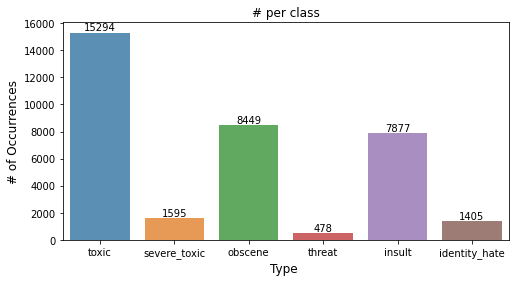

In [17]:
x = train.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Correlations of labels

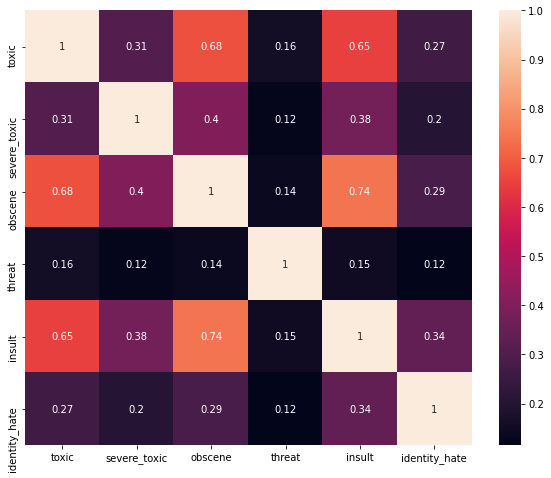

In [18]:
corr=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [20]:
print('Processing text dataset')
from collections import defaultdict

# regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# regex to replace all numeric
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def clean_text(text, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    text = special_character_removal.sub('',text)
    
    return text

Processing text dataset


In [21]:

train_comments = []

In [22]:
list_sentences_train = train["comment_text"].fillna("no comment").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = train[list_classes].values
#list_sentences_test = test_df["comment_text"].fillna("no comment").values

train_comments = [clean_text(text) for text in list_sentences_train]
#test_comments = [clean_text(text) for text in list_sentences_test]

In [23]:
assert len(train_comments) == 159571 , "It seems that you lost some data."
assert 'E' not in train_comments[0], "It seems you did not preprocess the sentecnes. I found a upper case alphabet in your train set."

In [25]:
for i in range(3):
    print("Cleaned\n", train_comments[i] + '\n')
    print("Raw\n", train.iloc[i]['comment_text'] + '\n')
    print("------------------")

Cleaned
 explanationwhy the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now    

Raw
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

------------------
Cleaned
 d aww he matches this background colour i am seemingly stuck with thanks talk  january   utc

Raw
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

------------------
Cleaned
 hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about th

## Tokenization:

In [29]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# Build the relation between words and ids 
tokenizer.fit_on_texts(train_comments )

## Encoding*

In [30]:

print(tokenizer.word_index['the']) # map 'the' to 1, map 'to' to 2,......
print(tokenizer.word_index['to'])

1
2


In [31]:
train_sequences = tokenizer.texts_to_sequences(train_comments)

In [32]:
for i in range(1):
    print("Transformed\n", str(train_sequences[i]) + '\n')
    print("Cleaned\n", train_comments[i] + '\n')
    print("------------------")

Transformed
 [92825, 1, 121, 124, 167, 28, 623, 4514, 10812, 1021, 82, 299, 47, 82, 11, 10813, 53, 6487, 15, 60, 2631, 141, 3, 2748, 34, 110, 1107, 15643, 2787, 5, 48, 21, 11, 229, 1, 399, 31, 1, 44, 29, 138, 3, 39, 3353, 87]

Cleaned
 explanationwhy the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now    

------------------


In [35]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', train_labels.shape)


Found 229952 unique tokens
Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 6)
